In [ ]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile, PDBxFile, Modeller, ForceField
from openff.toolkit import Molecule, Topology
from rdkit import Chem

import importlib 
import openff_agent.utils
importlib.reload(openff_agent.utils)

<module 'openff_agent.utils' from '/home/xlian/OpenffAgent/openff_agent/utils.py'>

In [ ]:
cif = '../tmp/ptm/pred.model_idx_0.cif'
fixed_pdb = '../tmp/ptm/pred.model_idx_0_fixed.pdb'

# fix cif to pdb
openff_agent.utils.fix_pdb(cif, fixed_pdb, resid_to_rm_atom={'126': ['HO1', 'H2']})

Fixed PDB file ../tmp/ptm/pred.model_idx_0.cif → ../tmp/ptm/pred.model_idx_0_fixed.pdb


In [ ]:
cif = '../tmp/noptm/pred.model_idx_0.cif'
fixer = PDBFixer(filename=cif)

#fixer.downloadTemplate('KPI')
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
#fixer.addMissingHydrogens(7.4)

modeller = Modeller(fixer.topology, fixer.positions)

forcefield = ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield, pH=7.4)

with open('../tmp/noptm_H.pdb', "w") as f:
    PDBFile.writeFile(modeller.topology, modeller.positions, f, keepIds=True)

In [1]:
with_h_path = '../tmp/noptm_H.pdb'
topology = Topology.from_pdb(with_h_path)
molecule = topology.molecule(0)

NameError: name 'Topology' is not defined

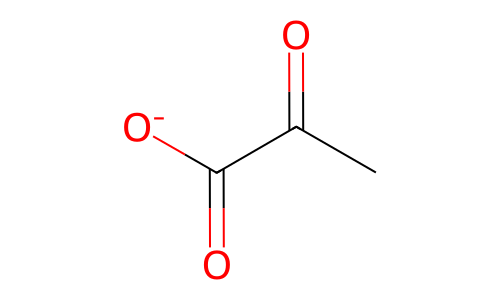

In [ ]:
pyruvate_addition = 'CC(=O)C(=O)[O-]'
pyruvate_addition_numbered = '[O-:1][C:2](=[O:3])[C:4]=[C:5]'
pyruvate_mal = Molecule.from_smiles(pyruvate_addition)
pyruvate_mal.visualize(show_all_hydrogens=False)

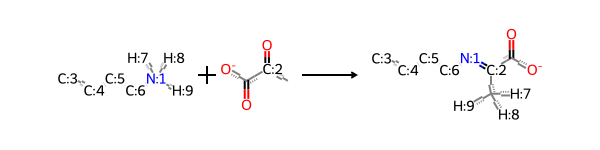

In [ ]:
ptm_rxn = Chem.rdChemReactions.ReactionFromSmarts(
    '[C:3][C:4][C:5][C:6][N;+1:1]([H:7])([H:8])[H:9].C[C:2](=O)C(=O)[O-]' # 给赖氨酸侧链的碳也编上号
    '>>'
    '[C:3][C:4][C:5][C:6][N;+0:1]=[C:2](C([H:7])([H:8])[H:9])(C(=O)[O-])'
)
ptm_rxn # this will give 42 product... this is the best result... other SMARTS don't work
# KPI in CCD doesn't have H on the N, so 

# RXNMapper could help this process so we don't need to manually write these stuff!!!!!!!!!
# Using RXNMapper to identify the reaction center

In [ ]:
amine = molecule.to_rdkit()
pyruvate = pyruvate_mal.to_rdkit()   # reagent

products = ptm_rxn.RunReactants([amine, pyruvate])
print("Number of products:", len(products))

Number of products: 42


18 126 [H]N(C)C(=O)[C@@]([H])(N([H])C(C)=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])N=C(C(=O)[O-])C([H])([H])[H]


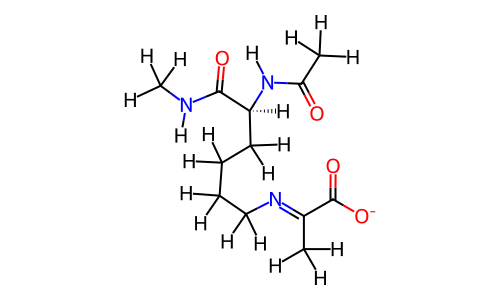

In [ ]:
# find the right product among the messy results...
for index, rdmol in enumerate(products):
    rxn = Chem.rdChemReactions.ReactionFromSmarts(
        '[C](=[O])[N:3]([H:4])[C:5][C:6](=[O:7])[N]' 
        + ' >> ' 
        + '[CH3]C(=O)[N:3]([H:4])[C:5][C:6](=[O:7])N([H])[CH3]'
    )
    cut_product = rxn.RunReactants([rdmol[0]])
    found_aa = False

    for product in cut_product:
        capped_aa = product[0]
        for atom in capped_aa.GetAtoms():
            res = atom.GetPDBResidueInfo()
            if res is None:
                continue
            if res.GetResidueName() == 'LYS' and 'C(=O)[O-]' in Chem.MolToSmiles(capped_aa):
                capped_ncaa = capped_aa
                chain_id = res.GetChainId()
                residue_number = res.GetResidueNumber() # 1-indexed
                if residue_number == 126:
                    found_aa = True
                    print(index, residue_number, Chem.MolToSmiles(capped_aa))
                    KPI_dgoa = rdmol[0]
                    Chem.SanitizeMol(capped_ncaa)
                    break
    if found_aa:
        break
offmol = Molecule.from_rdkit(capped_ncaa, allow_undefined_stereo=True)
offmol.generate_conformers()

for cap_resname, smarts, resoffset in [
    ("ACE", "[C:1]([H:2])([H:3])([H:4])[C:5](=[O:6])N", -1),
    ("NME", "[C:1]([H:2])([H:3])([H:4])[N:5]([H:6])C", +1), 
]: 
    matches = offmol.chemical_environment_matches(smarts, unique=True)
    for match in matches:
        for idx in match:
            atom = offmol.atom(idx)
            if atom.metadata.get("residue_name") is None:
                atom.metadata["residue_name"] = cap_resname
                atom.metadata["residue_number"] = residue_number + resoffset
                atom.metadata["insertion_code"] = " "
                atom.metadata["chain_id"] = chain_id
ncaa_capped = offmol

offmol.add_default_hierarchy_schemes()
offmol.visualize()

In [ ]:
Chem.SanitizeMol(KPI_dgoa)
labeled_smiles = Chem.MolToSmiles(KPI_dgoa)
smiles_path = '../tmp/noptm_H_add_KPI_smiles.txt'

with open(smiles_path, 'w') as f:
    f.write(labeled_smiles)

In [ ]:
protein_with_KPI = '../tmp/ptm_H_KPIasATOM_rmHonKPI.pdb'
labeled = Molecule.from_pdb_and_smiles(protein_with_KPI, labeled_smiles, allow_undefined_stereo=True)

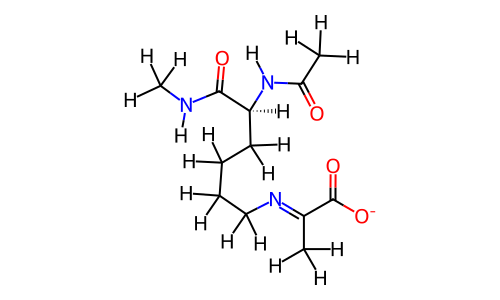

In [ ]:
def find_and_cap_residue(molecule, resname, allow_undefined_stereo=False):
    """
    Find the first residue with resname and extract and cap it
    """
    rdmol = molecule.to_rdkit()

    rxn = Chem.rdChemReactions.ReactionFromSmarts(
        '[C](=[O])[N:3]([H:4])[C:5][C:6](=[O:7])[N]' 
        + ' >> ' 
        + '[CH3]C(=O)[N:3]([H:4])[C:5][C:6](=[O:7])N([H])[CH3]'
    )
    products = rxn.RunReactants([rdmol])

    for product in products:
        capped_aa = product[0]
        for atom in capped_aa.GetAtoms():
            res = atom.GetPDBResidueInfo()
            if res is None:
                continue
            if res.GetResidueName() == resname:
                capped_ncaa = capped_aa
                chain_id = res.GetChainId()
                residue_number = res.GetResidueNumber()
                break

    Chem.SanitizeMol(capped_ncaa)
    
    offmol = Molecule.from_rdkit(capped_ncaa, allow_undefined_stereo=allow_undefined_stereo)
    offmol.generate_conformers()
    
    for cap_resname, smarts, resoffset in [
        ("ACE", "[C:1]([H:2])([H:3])([H:4])[C:5](=[O:6])N", -1),
        ("NME", "[C:1]([H:2])([H:3])([H:4])[N:5]([H:6])C", +1), 
    ]: 
        matches = offmol.chemical_environment_matches(smarts, unique=True)
        for match in matches:
            for idx in match:
                atom = offmol.atom(idx)
                if atom.metadata.get("residue_name") is None:
                    atom.metadata["residue_name"] = cap_resname
                    atom.metadata["residue_number"] = residue_number + resoffset
                    atom.metadata["insertion_code"] = " "
                    atom.metadata["chain_id"] = chain_id
    offmol.add_default_hierarchy_schemes()
    
    return offmol

ncaa_capped = find_and_cap_residue(labeled, "KPI", allow_undefined_stereo=True)
ncaa_capped.visualize()

191
126 [H]N(C)C(=O)[C@@]([H])(N([H])C(C)=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H]


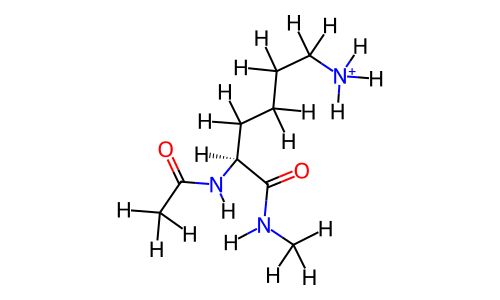

In [ ]:
def find_and_cap_residue(molecule, resname, allow_undefined_stereo=False):
    """
    Find the first residue with resname and extract and cap it
    """
    rdmol = molecule.to_rdkit()

    rxn = Chem.rdChemReactions.ReactionFromSmarts(
        '[C](=[O])[N:3]([H:4])[C:5][C:6](=[O:7])[N]' 
        + ' >> ' 
        + '[CH3]C(=O)[N:3]([H:4])[C:5][C:6](=[O:7])N([H])[CH3]'
    )
    products = rxn.RunReactants([rdmol])
    print(len(products))

    for product in products:
        capped_aa = product[0]
        for atom in capped_aa.GetAtoms():
            res = atom.GetPDBResidueInfo()
            if res is None:
                continue
            if res.GetResidueName() == resname:
                capped_ncaa = capped_aa
                chain_id = res.GetChainId()
                residue_number = res.GetResidueNumber() # 1-indexed
                if residue_number == 126:
                    print(residue_number, Chem.MolToSmiles(capped_aa))
                break

    Chem.SanitizeMol(capped_ncaa)
    
    offmol = Molecule.from_rdkit(capped_ncaa, allow_undefined_stereo=allow_undefined_stereo)
    offmol.generate_conformers()
    
    for cap_resname, smarts, resoffset in [
        ("ACE", "[C:1]([H:2])([H:3])([H:4])[C:5](=[O:6])N", -1),
        ("NME", "[C:1]([H:2])([H:3])([H:4])[N:5]([H:6])C", +1), 
    ]: 
        matches = offmol.chemical_environment_matches(smarts, unique=True)
        for match in matches:
            for idx in match:
                atom = offmol.atom(idx)
                if atom.metadata.get("residue_name") is None:
                    atom.metadata["residue_name"] = cap_resname
                    atom.metadata["residue_number"] = residue_number + resoffset
                    atom.metadata["insertion_code"] = " "
                    atom.metadata["chain_id"] = chain_id
    offmol.add_default_hierarchy_schemes()
    
    return offmol

ncaa_capped = find_and_cap_residue(molecule, "LYS", allow_undefined_stereo=True)
ncaa_capped.visualize()

In [ ]:
ncaa_capped.assign_partial_charges('am1bcc')
#ncaa_capped.partial_charges

ValueError: No registered toolkits can provide the capability "assign_partial_charges" for args "()" and kwargs "{'molecule': Molecule with name '' and SMILES '[H][N]([C](=[O])[C@@]([H])([N]([H])[C](=[O])[C]([H])([H])[H])[C]([H])([H])[C]([H])([H])[C]([H])([H])[C]([H])([H])[N+]([H])([H])[H])[C]([H])([H])[H]', 'partial_charge_method': 'am1bcc', 'use_conformers': None, 'strict_n_conformers': False, 'normalize_partial_charges': True, '_cls': <class 'openff.toolkit.topology.molecule.Molecule'>}"
Available toolkits are: [ToolkitWrapper around The RDKit version 2025.09.3, ToolkitWrapper around Built-in Toolkit version None]
 ToolkitWrapper around The RDKit version 2025.09.3 <class 'openff.toolkit.utils.exceptions.ChargeMethodUnavailableError'> : partial_charge_method 'am1bcc' is not available from RDKitToolkitWrapper. Available charge methods are {'mmff94': {}, 'gasteiger': {}}
 ToolkitWrapper around Built-in Toolkit version None <class 'openff.toolkit.utils.exceptions.ChargeMethodUnavailableError'> : Partial charge method "am1bcc"" is not supported by the Built-in toolkit. Available charge methods are {'zeros': {'rec_confs': 0, 'min_confs': 0, 'max_confs': 0}, 'formal_charge': {'rec_confs': 0, 'min_confs': 0, 'max_confs': 0}}


In [ ]:

# Make unnatural AA as its own mol. Since a residue is a substructure, not a valid molecule,
# use something that's easy to recognize as a "cap". Here I use Fr since it makes one bond and
# we're super unlikely to see Fr anywhere else.
substructure_mols = [
    Molecule.from_smiles(
        'C/C(=N\CCCC[C@@H](C(=O)[Fr])N[Fr])/C(=O)[O-]'
        #'[Fr]C(=O)[C@@]([H])(N([H])([Fr]))C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])C(=C)C(=O)[O-]' #KPJ
        #"[Fr]N[C@@H](CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@@H](C(=O)O)NC(=O)CCCCCCCCCCCCCCCCC(=O)O)C(=O)[Fr]",
    )
]

# Label the atoms with whether they're leaving
for substructure in substructure_mols:
    for atom in substructure.atoms:
        if atom.symbol == "Fr":
            atom.metadata["substructure_atom"] = False
        else:
            atom.metadata["substructure_atom"] = True


<>:6: SyntaxWarning: invalid escape sequence '\C'
<>:6: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipykernel_2176392/3638309212.py:6: SyntaxWarning: invalid escape sequence '\C'
  'C/C(=N\CCCC[C@@H](C(=O)[Fr])N[Fr])/C(=O)[O-]'


In [ ]:
pdb_path = '../tmp/ptm_H_KPIasATOM_rmHonKPI_fixLEU.pdb'

#from openff_agent.struct_fixer import 

top = Topology.from_pdb(
    pdb_path,
    # _additional_substructures is a PROTOTYPE.
    # Its behavior and input type are likely to change.
    _additional_substructures=substructure_mols, 
)

UnassignedChemistryInPDBError: Some bonds or atoms in the input could not be identified.

Hint: The following residue names with unassigned atoms were not found in the substructure library. While the OpenFF Toolkit identifies residues by matching chemical substructures rather than by residue name, it currently only supports the 20 'canonical' amino acids.
    FCK


Hint: The following residues were assigned names that do not match the residue name in the input, or could not be assigned residue names at all. This may indicate that atoms are missing from the input or some other error. The OpenFF Toolkit requires all atoms, including hydrogens, to be explicit in the input to avoid ambiguities in protonation state or bond order:
    Input residue A:FCK#0126 contains atoms matching substructures {'NO MATCH', 'NH2'}

Error: The following 25 atoms exist in the input but could not be assigned chemical information from the substructure library:
    Atom  1852 (CA) in residue A:FCK#0126
    Atom  1853 (HA) in residue A:FCK#0126
    Atom  1854 (CB) in residue A:FCK#0126
    Atom  1855 (HB) in residue A:FCK#0126
    Atom  1856 (HBA) in residue A:FCK#0126
    Atom  1857 (CG) in residue A:FCK#0126
    Atom  1858 (HG) in residue A:FCK#0126
    Atom  1859 (HGA) in residue A:FCK#0126
    Atom  1860 (CD) in residue A:FCK#0126
    Atom  1861 (HD) in residue A:FCK#0126
    Atom  1862 (HDA) in residue A:FCK#0126
    Atom  1863 (CE) in residue A:FCK#0126
    Atom  1864 (HE) in residue A:FCK#0126
    Atom  1865 (HEA) in residue A:FCK#0126
    Atom  1866 (NZ) in residue A:FCK#0126
    Atom  1867 (CX1) in residue A:FCK#0126
    Atom  1868 (C1) in residue A:FCK#0126
    Atom  1869 (H1C) in residue A:FCK#0126
    Atom  1870 (H1A) in residue A:FCK#0126
    Atom  1871 (H1B) in residue A:FCK#0126
    Atom  1872 (CX2) in residue A:FCK#0126
    Atom  1873 (O1) in residue A:FCK#0126
    Atom  1874 (O2) in residue A:FCK#0126
    Atom  1875 (C) in residue A:FCK#0126
    Atom  1876 (O) in residue A:FCK#0126
